# *Standard Libraries*

In [1]:
import datetime
import numpy as np
import pandas as pd
import datatable as dt
pd.set_option("display.max_columns", None, "display.max_rows", None)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
%%time
train = dt.fread('../input/g-research-crypto-forecasting/train.csv').to_pandas()

CPU times: user 14.1 s, sys: 11.7 s, total: 25.9 s
Wall time: 38.1 s


In [3]:
train = train.set_index('timestamp')
train.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [4]:
for i in range(14):
    print(i, len(train[train.Asset_ID == i])%60)

0 59
1 42
2 57
3 27
4 6
5 40
6 20
7 47
8 31
9 30
10 57
11 21
12 49
13 40


In [5]:
train = train.sort_index()
ind = train.index.unique()
def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    # fill null values with zeros for visualization
    df = df.fillna(0).fillna(0)
    return df
train = train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()

In [6]:
# ensure dataframe is well padded
for i in range(14):
    print(i, len(train[train.Asset_ID == i])%60)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0


In [7]:
# ensure there is no null values in the dataframe
train.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [8]:
train = train.reset_index()
# sort dataframe by timestamp then by asset id for consistency
train = train.sort_values(by=['timestamp', 'Asset_ID'])
# convert date to datetime to enable extracting more useful info
train['date'] = pd.to_datetime(train.timestamp, unit='s')
train.drop(['timestamp'], axis=1, inplace=True)

In [9]:
# extract useful features from the datetime feature
train['min_'] = pd.DatetimeIndex(train['date']).minute.astype('uint8')
train['hr_'] = pd.DatetimeIndex(train['date']).hour.astype('uint8')
train['day_'] = pd.DatetimeIndex(train['date']).day.astype('uint8')
train['day_in_week'] = pd.DatetimeIndex(train['date']).day_of_week.astype('uint8')
train['week'] = pd.DatetimeIndex(train['date']).week.astype('uint8')
train['month'] = pd.DatetimeIndex(train['date']).month.astype('uint8')
train['is_month_start'] = pd.DatetimeIndex(train['date']).is_month_start.astype(int).astype('uint8')
train['is_month_end'] = pd.DatetimeIndex(train['date']).is_month_end.astype(int).astype('uint8')
train['is_quarter_start'] = pd.DatetimeIndex(train['date']).is_quarter_start.astype(int).astype('uint8')
train['is_quarter_end'] = pd.DatetimeIndex(train['date']).is_quarter_end.astype(int).astype('uint8')
train['is_year_start'] = pd.DatetimeIndex(train['date']).is_year_start.astype(int).astype('uint8')
train['is_year_end'] = pd.DatetimeIndex(train['date']).is_year_end.astype(int).astype('uint8')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


In [10]:
# convert float columns to float64 to reduce memory usage
float_cols = []
for col in train.columns.tolist():
    if train[col].dtypes == 'float64':
        float_cols.append(col)
    
train[float_cols] = train[float_cols].astype('float16')

# *EDA*

#### *In this section will display only the data of Bitcoin (Asset_ID = 1) for the sake of simplicity. You can also explore other assets.*

In [11]:
# select only date from 2021 for computational simplicity
df = train[train['date'] >= datetime.datetime(2021, 1, 1)].set_index('date', drop=True)
print(df.shape)

(5302094, 21)


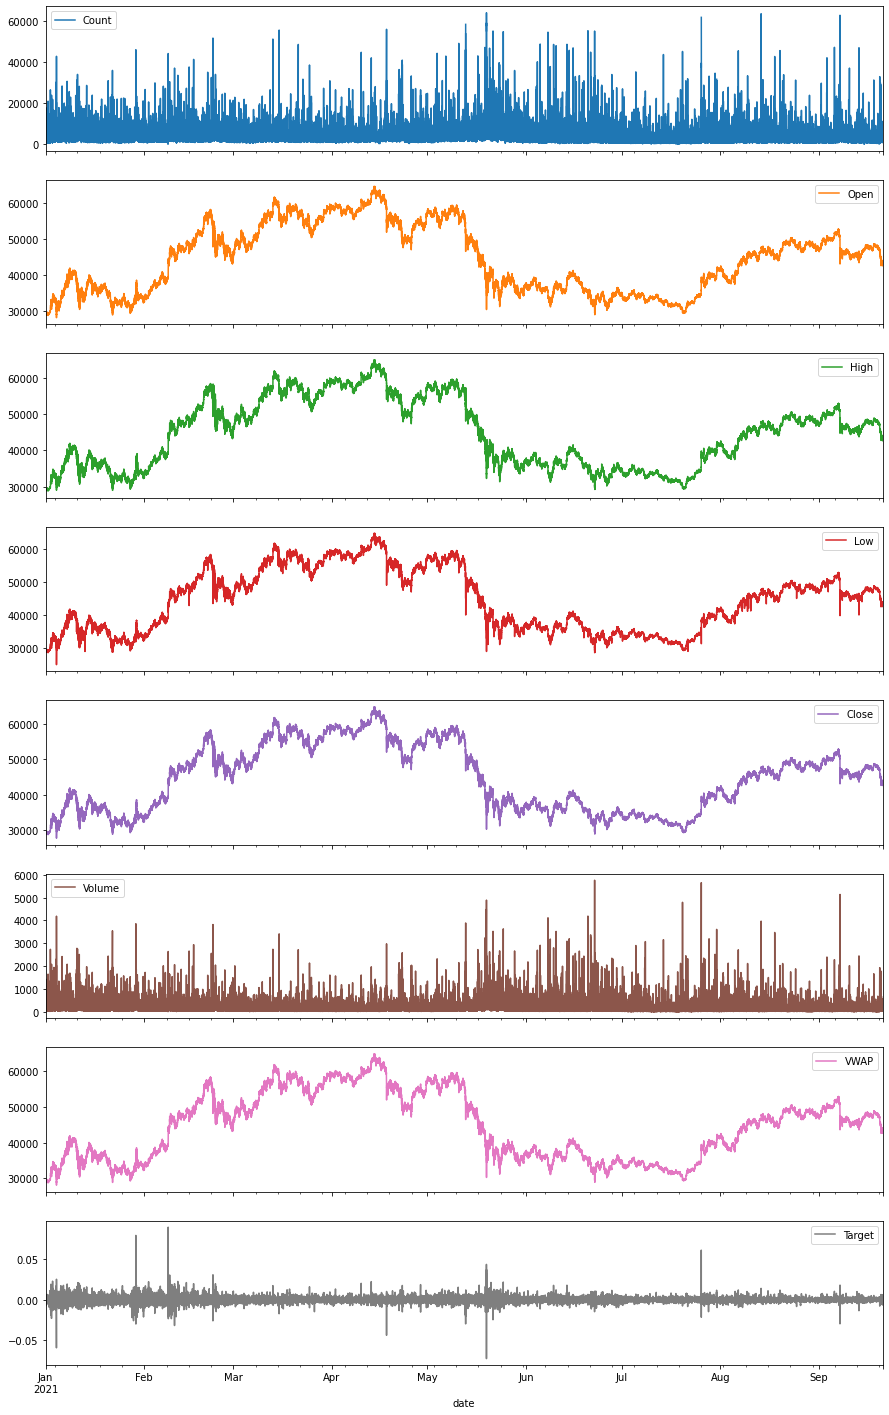

In [12]:
# from the line plot we can extract info on trends and seasonality
df[df['Asset_ID'] == 1][['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']].plot(subplots=True, figsize=(15, 25))
plt.show()

#### *We can see how the Target and the features are extremely noisy and hence we will try to smoothen these curves using some techniques. This might enable us to extract valuable information from our data*

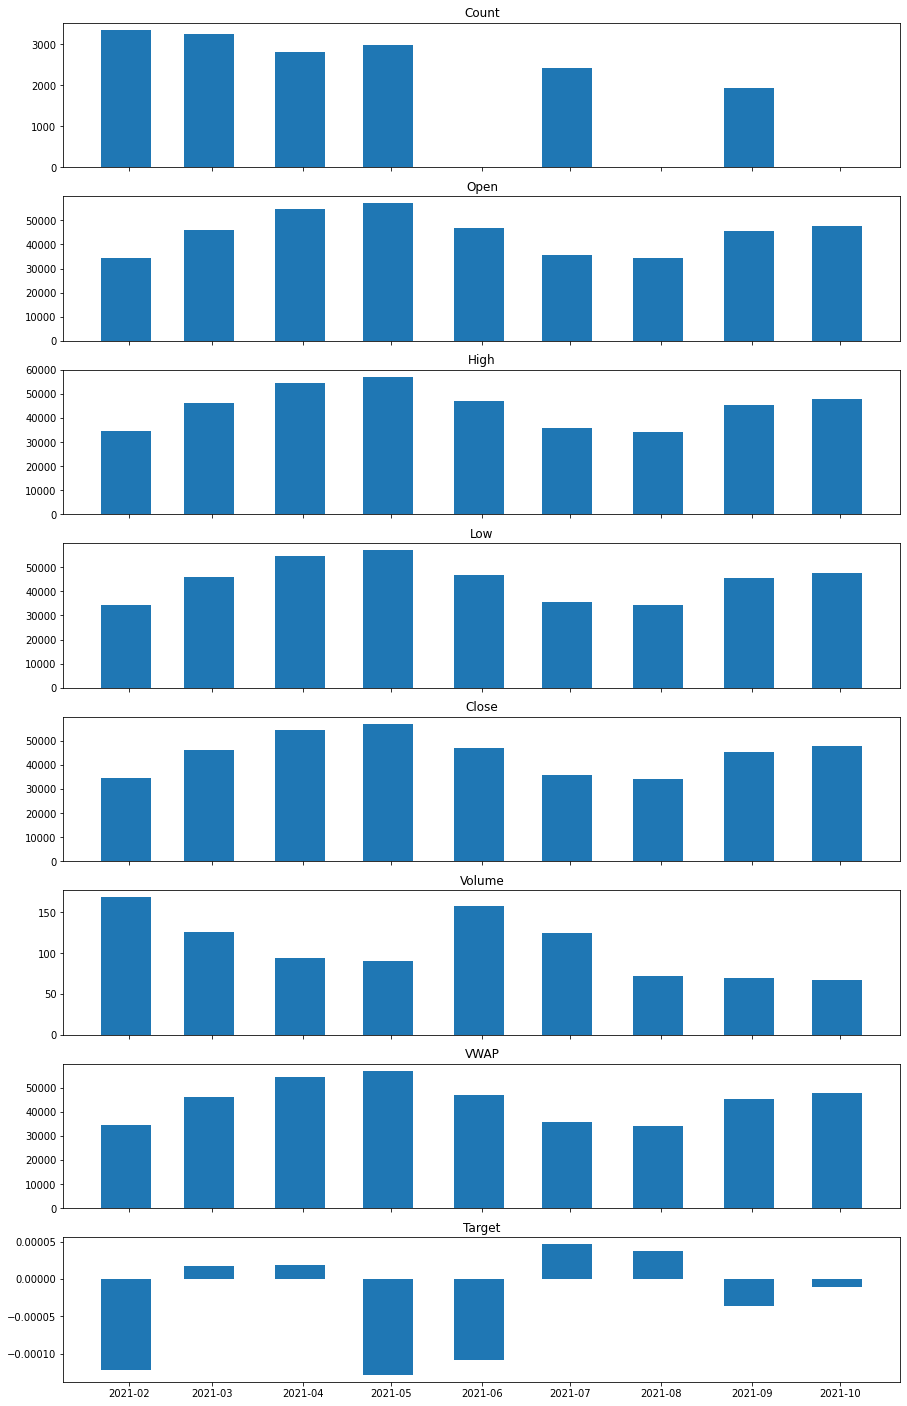

In [13]:
# first method to smoothen the curves is by resampling (aggregating) data over a wider period of time and taking the mean of these values
df_month = df[df['Asset_ID'] == 1].resample("M").mean()

fig, axes = plt.subplots(8, 1, figsize=(15, 25), sharex=True)
for name, ax in zip(['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target'], axes):
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.bar(df_month.index, df_month[name], width=17, align='center')
    ax.set_ylabel("")
    ax.set_title(name)
    if ax != axes[-1]:
        ax.set_xlabel('')

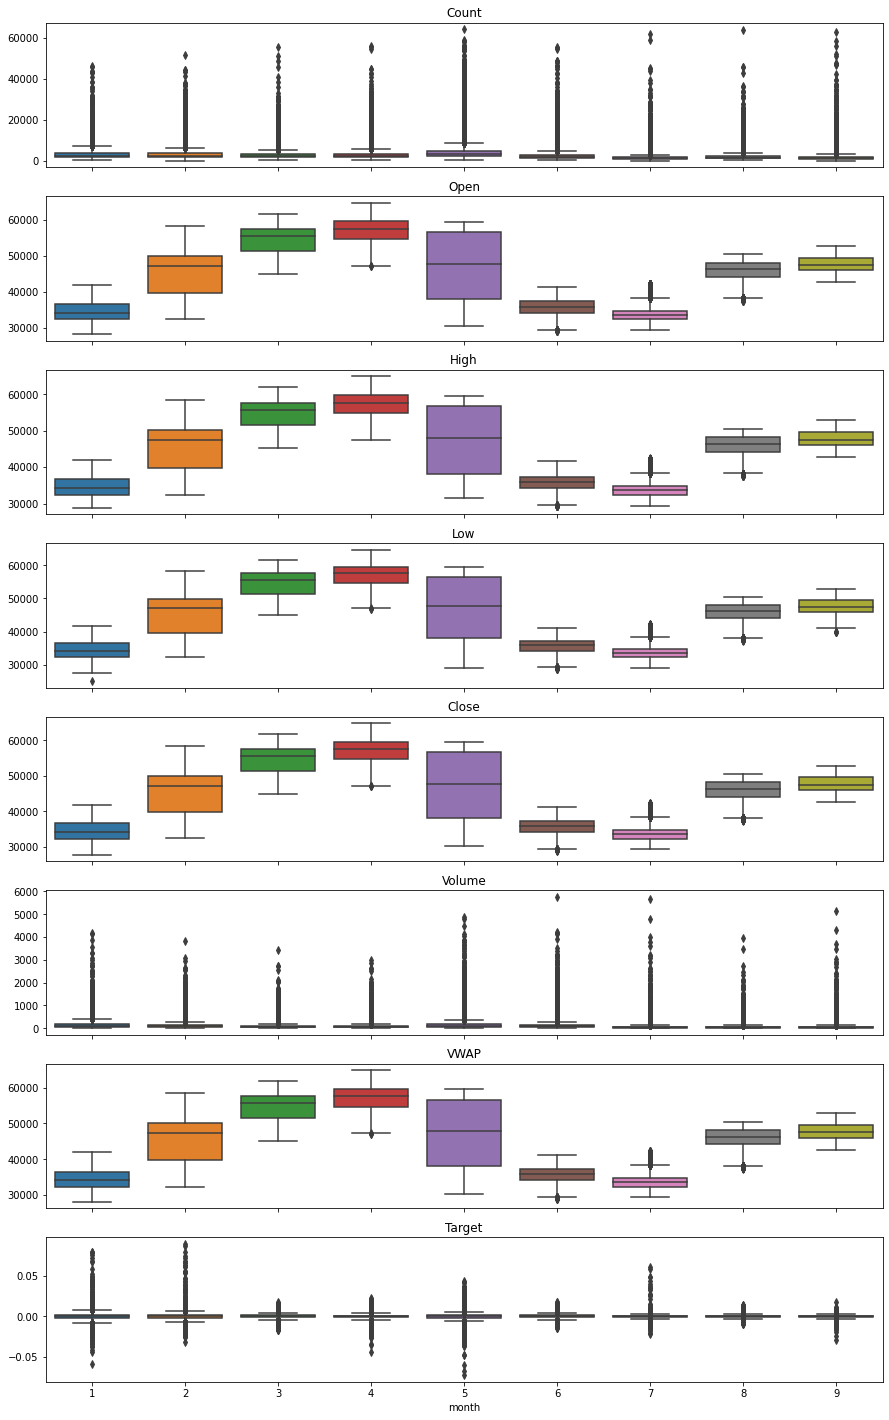

In [14]:
# boxplots provides us with more precious information where some important stats as median, interquartile range, outliers can be 
# explored
fig, axes = plt.subplots(8, 1, figsize=(15, 25), sharex=True)
for name, ax in zip(['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target'], axes):
    sns.boxplot(data = df[df['Asset_ID'] == 1], x='month', y=name, ax=ax)
    ax.set_ylabel("")
    ax.set_title(name)
    if ax != axes[-1]:
        ax.set_xlabel('')
plt.savefig("fig_4.png")

In [15]:
# again we perform resampling and rolling, but this time on a daily basis which might provide more specific info
df_day = df[df['Asset_ID'] == 1].resample("D").mean()
df_day = df_day.fillna(0)

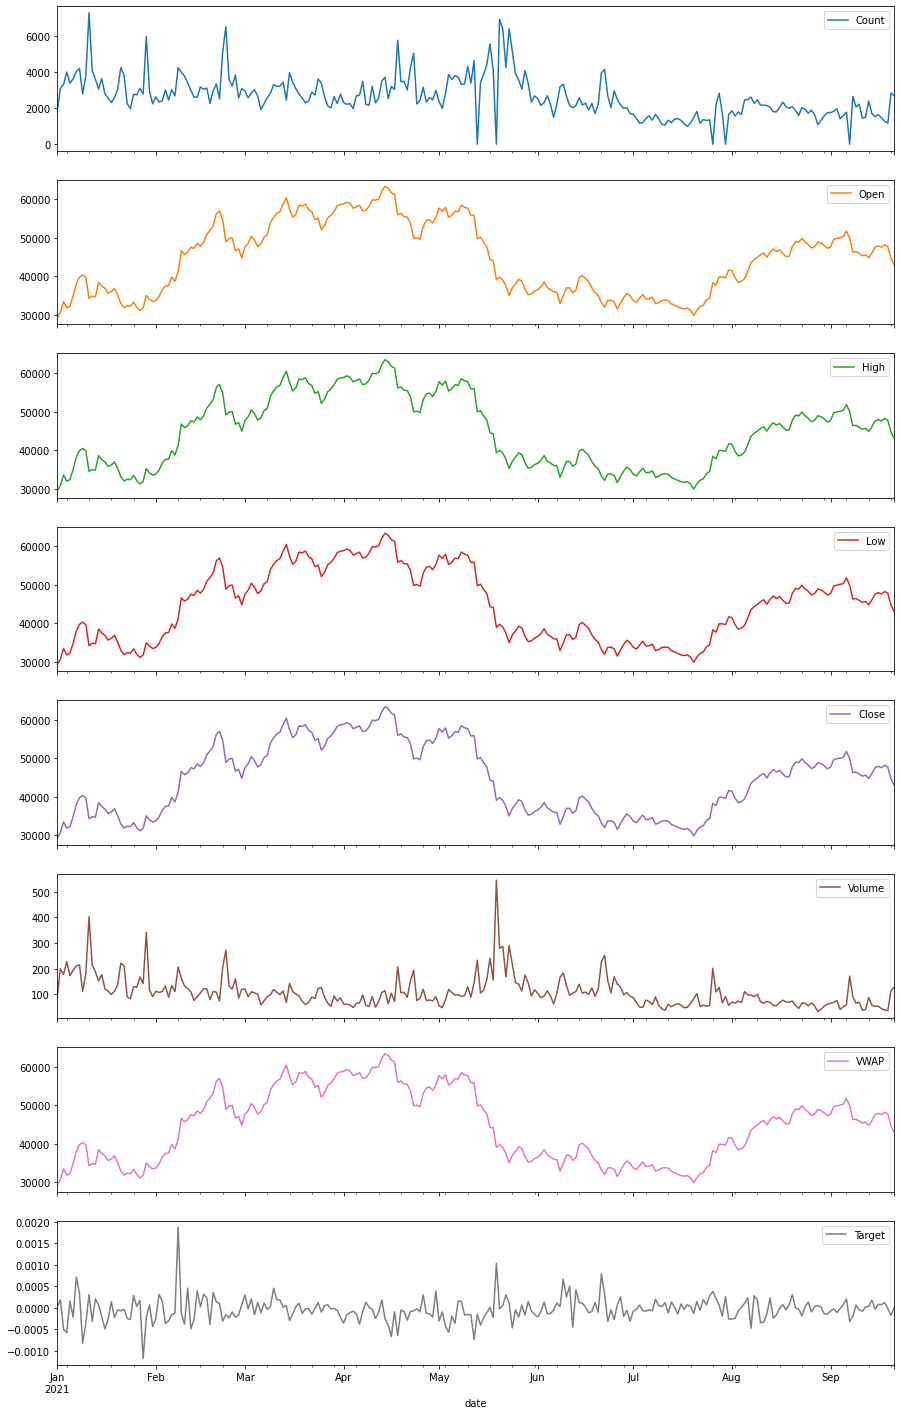

In [16]:
# from the line plot we can extract info on daily trends and seasonality
df_day[df_day['Asset_ID'] == 1][['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']].plot(subplots=True, figsize=(15, 25))
plt.show()

In [17]:
# we still see a lot of spikes which are not helpful for modelling
# let's smooth them down by resampling to a lower freq and rolling
df_week = df[df['Asset_ID'] == 1].resample("W").mean()

In [18]:
df_week = df_week.astype('float64')
df_week = df_week.fillna(method='pad')

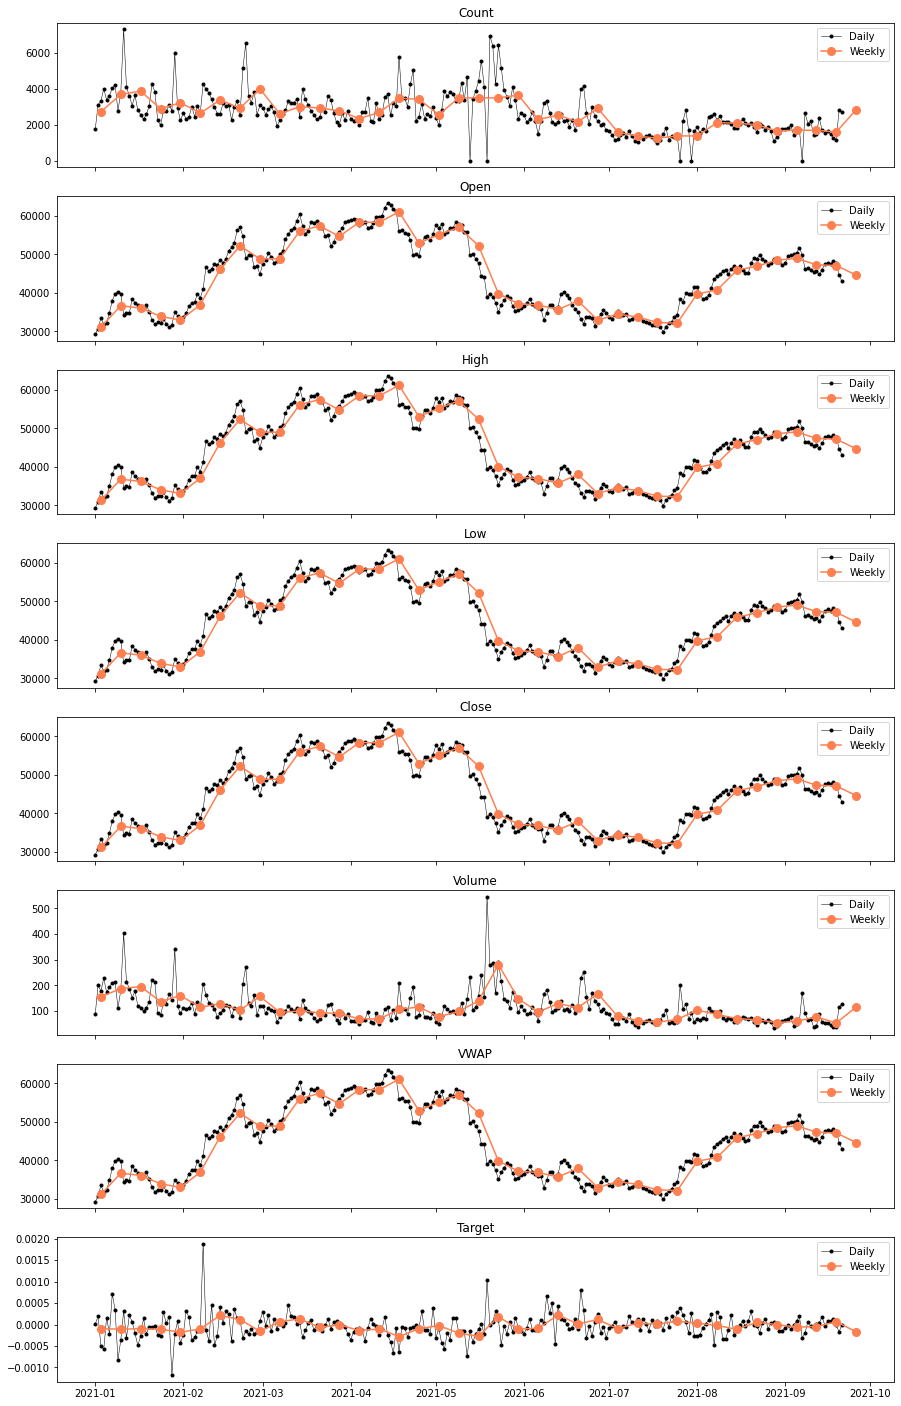

In [19]:
# here we compare the daily trends and seasonality to the weekly ones
fig, axes = plt.subplots(8, 1, figsize=(15, 25), sharex=True)
for name, ax in zip(['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target'], axes):
    ax.plot(df_day[name], marker='.', linestyle='-', linewidth = 0.5, label='Daily', color='black')
    ax.plot(df_week[name], marker='o', markersize=8, linestyle='-', label='Weekly', color='coral')
    ax.set_ylabel(name)
    ax.legend()
    ax.set_ylabel("")
    ax.set_title(name)
    if ax != axes[-1]:
        ax.set_xlabel('')

In [20]:
cols = ['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']
for col in cols:
    df_week[f'{col}_Change'] = df_week[col].div(df_week[col].shift())
    
df_week = df_week.fillna(method='bfill')

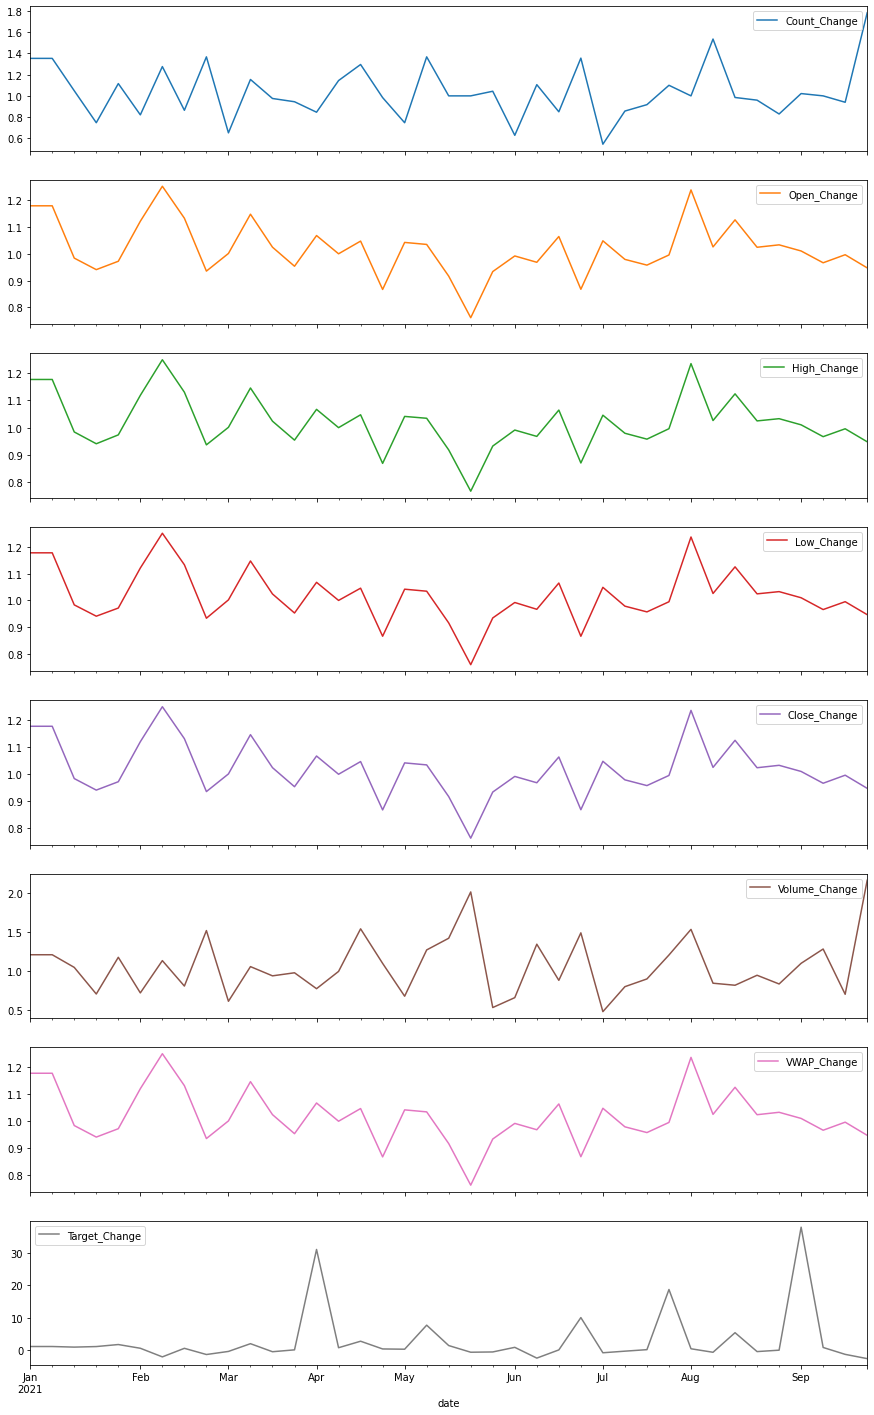

In [21]:
# plot the weekly change =====> thisWeekReading / previousWeekReading
# this enables us to trace the trend of the ratio of these features. 
# wherever the value is greater than one, this means that this feature 
# has reported an increment from the previous week 
df_week[df_week['Asset_ID'] == 1][[f'{col}_Change' for col in ['Count', 'Open', 'High', 'Low', 'Close', 
                                                               'Volume', 'VWAP', 'Target']]].plot(subplots=True, figsize=(15, 25))
plt.show()

In [22]:
# in many cases percent change is informative
cols = ['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']
for col in cols:
    df_week[f'{col}_pct_change'] = df_week[col].pct_change()*100
    
df_week = df_week.fillna(method='bfill')

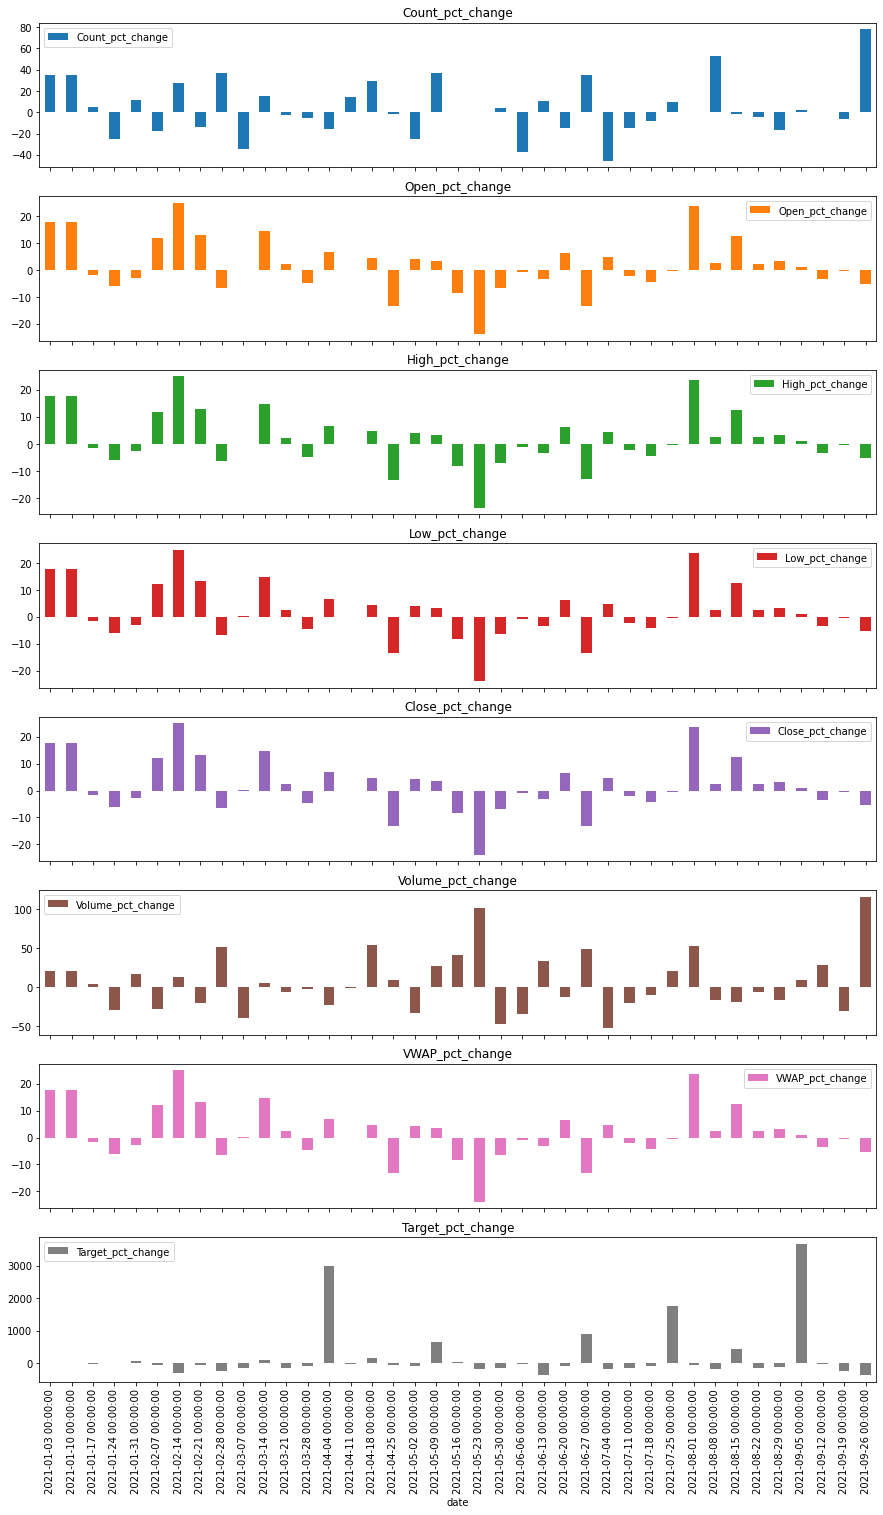

In [23]:
# plot the weekly change =====> thisWeekReading / previousWeekReading
df_week[df_week['Asset_ID'] == 1][[f'{col}_pct_change' for col in ['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']]]\
                                                                    .plot(kind='bar', subplots=True, figsize=(15, 25))
plt.show()

In [24]:
# here for each column we plot the original values versus the expanding mean (cumulative mean) versus the expanding std

cols = ['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']
for col in cols:
    df_week[f'{col}_expanding_mean'] = df_week[col].expanding().mean()
    df_week[f'{col}_expanding_std'] = df_week[col].expanding().std()

df_week = df_week.fillna(method='bfill')

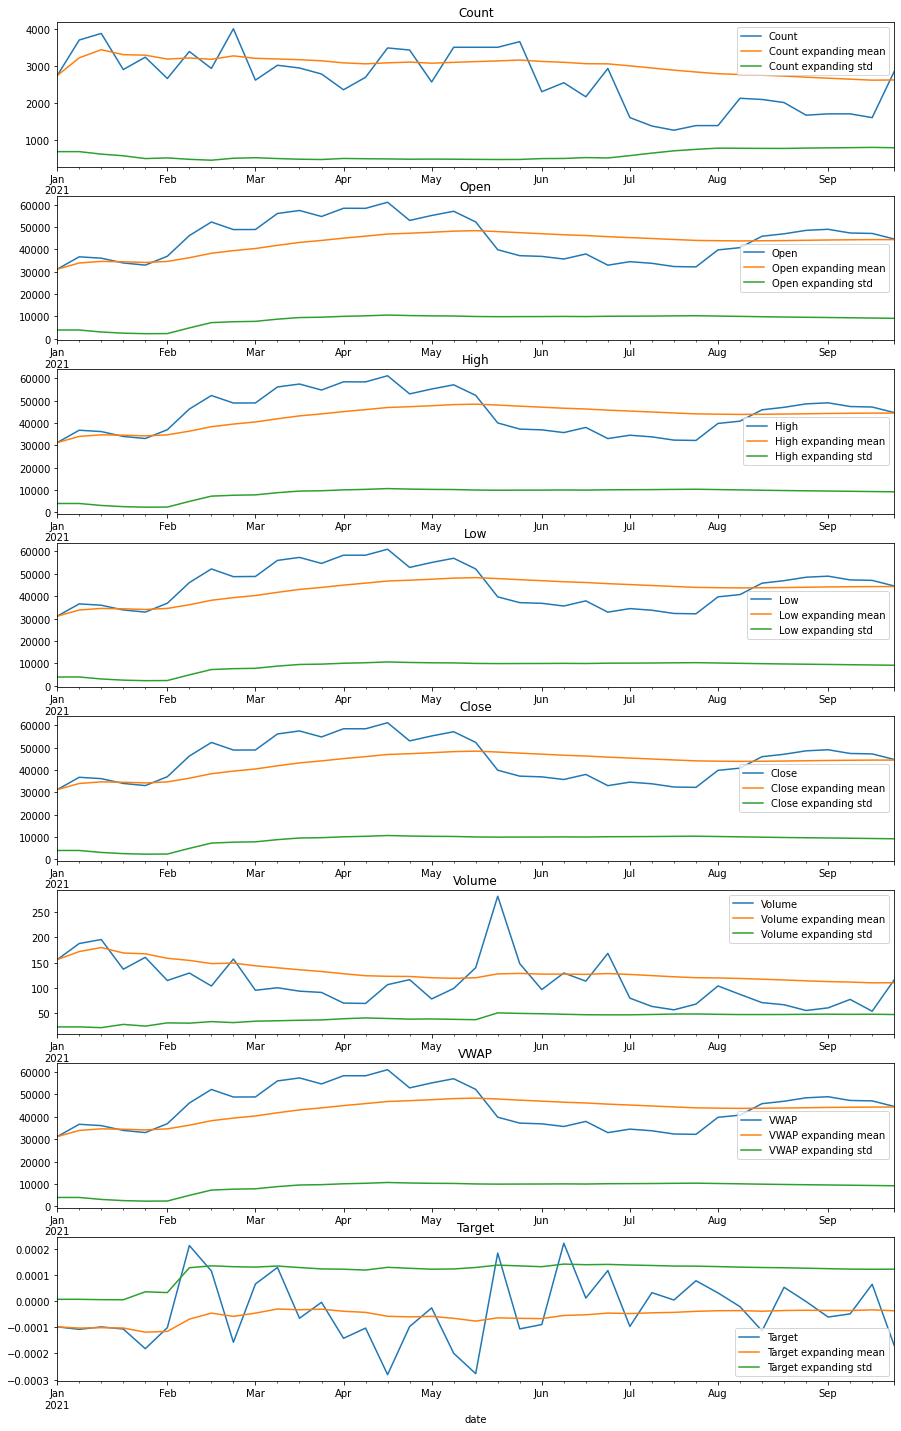

In [25]:
# here for each column we plot the original values versus the expanding mean (cumulative mean) versus the expanding std

fig, axes = plt.subplots(8, 1, figsize=(15, 25), sharex=False)
for i, (name, ax) in enumerate(zip(['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target'], axes)):
    plt.subplot(8, 1, i+1)
    ax = df_week[f'{name}'].plot(label=name)
    ax = df_week[f'{name}_expanding_mean'].plot(label=f'{name} expanding mean')
    ax = df_week[f'{name}_expanding_std'].plot(label=f'{name} expanding std')
    ax.set_ylabel(name)
    ax.legend()
    ax.set_ylabel("")
    ax.set_title(name)
    if ax != axes[-1]:
        ax.set_xlabel('')

plt.show()

#### *These plots assures the high volatility of the data, where data statistics such as mean and standard deviation are varying over time.*

In [26]:
df_hour = df[df['Asset_ID'] == 1].resample("H").mean().astype('float64')
df_hour = df_hour.fillna(method='pad')

df_hour['day_'] = df_hour['day_'].astype(int)
df_hour['hr_'] = df_hour['hr_'].astype(int)

In [27]:
hour_day_df = pd.pivot_table(df_hour, 
                             values="Close",
                             index=['hr_'],
                             columns=['day_'],
                             fill_value=0,
                             margins=True)

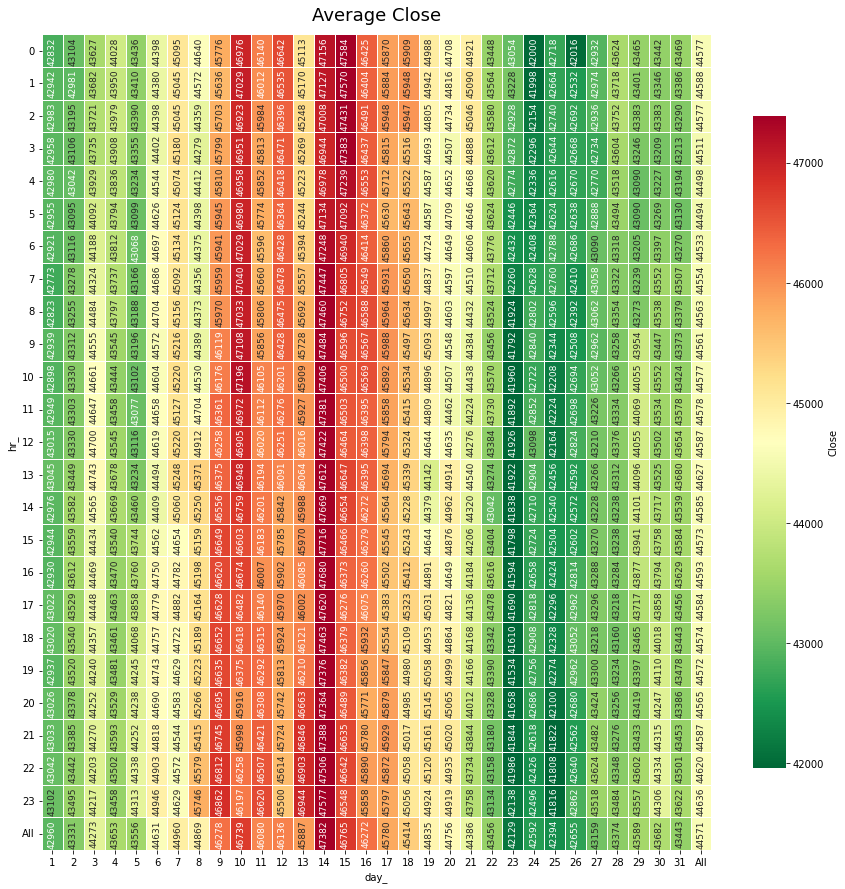

In [28]:
# this heat map enables us to keep track of hours of all days over all months and see which hours of day had the 
# the highest mean close value and which ones had the smallest values 
plt.figure(figsize=(15, 15))
ax = sns.heatmap(hour_day_df, cmap='RdYlGn_r', robust=True, fmt='.0f', 
                 annot=True, linewidths=.5, annot_kws={'size':9, 'rotation': 90}, 
                 cbar_kws={'shrink':.8, 'label':'Close'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Average Close', fontdict={'fontsize':18},    pad=14)
plt.show()

#### *We can see that on average the days with the high opening values take place during the half of the month, especially between the 9th and 17th day*  